# Introduction to Word Embedding 

Natural language processing is now everywhere. From Google search, google translate, analyzing product reviews in ecommarce sites like Amazon or in doing sentiment analysis on particular topics in Twitter, using machine learning for nlp is becoming more important every minute. There's many popular ways to transform raw text to numbers to use in a machine learning model such as bag of words or tf-idf(term frequency inverse document frequency). 

The limitation with most of these methods is that they don't capture meaning. If we only count the number of times each word appears in the text (bag of words) or even weight it with number of times those words appear in the documents(tf-idf), we still do not have any notion about which words are truly similar or share similar meaning. Word Embedding is an unsupervised technique for capturing word meanings, understanding semantic relationships between them by creating representation for words. 


In this tutorial we will cover following things: 

* Definition of word embeddings
* How to train our own word embeddings with gensim
* Visualizing the word embeddings using TSNE
* Using pre-trained word vectors
* How to use word embeddings for text classification

# What are Word Embeddings?

Word embeddings ( also called word vectors) are mappings from words to real valued vectors. The key idea is that each word will be represented by a numeric vector. It is a dense representation of words in a low dimensional vector space.

If we simply want to represent a word by a vector, we can use the one-hot-representation. Here the length of the vector corresponds to the size of total vocabulary. Each vector will have a non-zero-entry(1) in its place in the vocabulary.

For example if we have a 3 word vocabulary ```{book, king, queen}```, we can have 3 word vectors like this.

```
book = [1,0,0]
king = [0,1,0]
queen = [0,0,1]
```
However if we have one million words in our vocabulary then we have vectors of 1 million length with only one non-zero-entry which would be very sparse vectors. One-hot-representations work well for discrete values of categorical data well, but they can also be inefficient when the vectors are very sparse. This takes a huge space in memory and when it comes to computing with these vectors(addition, multiplication) etc it'd take a lot of time.

On top of that, one-hot-representations do not preserve similarity or relationships between words. The vector for king and the vector for queen does not have any similarity between them. If we take the dot product between these two vectors we will end up with a zero even if both words appear in similar contexts. One-hot-representations do not preserve semantic relationships.

The solution is to create a 'distributed representation' that preserves the notion of similarity in a low-dimensional space. Word embeddings create a low dimensional(length of 50,100,300 etc instead of 1M+) vector containing real numbers where the meaning of the words is distributed through all the dimensions in the vector instead of just having one non-zero entry. In practice the word vectors may look like this : 

```
book = [.34,.56,.22]
king = [.94,.75,.83]
queen = [.92,.70,.78]
```

Here we will go through a brief overview of the popular word embedding models. 

* ```Word2vec``` :  Word2Vec was released by a team of researchers at Google led by Tomas Mikolov in 2013. Since then many other researchers have also explained word2vec...[more here]


* ```Glove``` : [Glove](https://nlp.stanford.edu/projects/glove/) (Global Vectors for Word Representation) was created by Stanford NLP group. They provide many pre-trained vectors of different dimensions(50,100,200 or 300 dimensions) trained on Wikipedia and Twitter corpus for general use. [more here]


* ```FastText``` : [FastText](https://github.com/facebookresearch/fastText) is the latest word embedding library released by Facebook in 2016. Unlike Word2Vec and Glove, FastText treats words as composed of its character n-grams. Vectors created for one word is the sum of vectors created for its character n-grams. For example, the vector for orange might be the sum of the vectors of the character level bigrams like ```or|ra|an|ng|ge|e```  and trigrams like ```ora|ran|ang|nge|ge|e```. This helps to generate better representations for out-of-vocabulary words and rare words because even if the word does not appear in the corpus or appears very infrequently it can still have character n-grams shared with other words. FastText also released pre-trained word vectors for 294 languages trained on wikipedia corpus in 2017.

# Training Word Embeddings

Now that we have some idea about what word embeddings are we can easily train our own word embeddings using Gensim wrapper for [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html) and visualize the embeddings using t-sne from scikit learn. 

The dataset we will use comes from [Project Gutenberg](https://www.gutenberg.org/).[Pride and Prejudice](https://en.wikipedia.org/wiki/Pride_and_Prejudice) is a famous romance novel written by [Jane Austen](https://en.wikipedia.org/wiki/Jane_Austen), a very well-known author from late 18th century. The book was first published in 1813. Later many modern movies and dramas have been made out of the book. 

We'll get the data from Project Gutenberg and preprocess the data for making it ready for the gensim word2vec model. Then we will train the word embeddings with gensim's word2vec.

First we'll load all the libraries we may need. Here's a brief review of how each library will be used : 

* ```gensim``` : To create word vectors
* ```requests``` : To get the data from Project Gutenberg
* ```re``` : Regex for cleaning the dataset
* ```numpy```, ```sklearn```,```matplotlib``` : For plotting the word vectors in 2 dimension with TSNE

In [2]:
import gensim
import requests
import re
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

## Data Preprocessing

Here we have a few helper function for collecting the text of the book from Project Gutenberg. The function ```get_book``` gets the pride and prejudice text from the project gutenberg website and discards some extra text for processing. 

```preprocess``` function keeps only the alpha-numeric characters and removes all special characters. It also makes the text lowercase and splits it into a list of sentences.

```get_book_corpus``` function uses both of the helper functions ```get_book``` and ```preprocess``` to get the book text as a list of sentences. Then it breaks up the sentences into words for tokenization and returns the corpus. 

In [31]:
pride_and_prejudice_url = 'http://www.gutenberg.org/files/1342/1342-0.txt'

def get_book(url):
    # gets the text from project gutenberg with a http request
    raw = requests.get(url).text
    # each book in project gutenberg has some metadata in the beginning so we discard them
    start = re.search(r"\*\*\* START OF THIS PROJECT GUTENBERG EBOOK .* \*\*\*",raw ).end()
    # similarly there's some extra text in the end too, so we discard them
    stop = re.search(r"End of the Project Gutenberg EBook", raw).start()
    # we only keep the relevant text
    text = raw[start:stop]
    return text


def preprocess(sentence): 
    return re.sub('[^A-Za-z0-9.]+', ' ', sentence).lower().split(".")
    

def get_book_corpus(book_url):
    book = get_book(book_url)
    processed_book = preprocess(book)
    corpus = [sentence.split(" ") for sentence in processed_book]
    return corpus


In [32]:
pride_and_prejudice = get_book_corpus(pride_and_prejudice_url)
corpus = pride_and_prejudice


As we can see, we have the word tokenized version of the famous first two opening sentences from pride and prejudice with some extra header words.

In [43]:
print(corpus[0:2])

[['', 'produced', 'by', 'anonymous', 'volunteers', 'pride', 'and', 'prejudice', 'by', 'jane', 'austen', 'chapter', '1', 'it', 'is', 'a', 'truth', 'universally', 'acknowledged', 'that', 'a', 'single', 'man', 'in', 'possession', 'of', 'a', 'good', 'fortune', 'must', 'be', 'in', 'want', 'of', 'a', 'wife'], ['', 'however', 'little', 'known', 'the', 'feelings', 'or', 'views', 'of', 'such', 'a', 'man', 'may', 'be', 'on', 'his', 'first', 'entering', 'a', 'neighbourhood', 'this', 'truth', 'is', 'so', 'well', 'fixed', 'in', 'the', 'minds', 'of', 'the', 'surrounding', 'families', 'that', 'he', 'is', 'considered', 'the', 'rightful', 'property', 'of', 'some', 'one', 'or', 'other', 'of', 'their', 'daughters']]


There's some uninformative words in text like blank space("") and many stopwords like a, the etc which occur frequently but does not add much to the meaning of the sentences. It's not that big of a problem when we are training on millions of news articles and want to improve classification accuracy on something like google search, but here we are going to visualize the embeddings, so it's better if we can get a good vocabulary set. We get the final corpus after removing the stopwords with the help of [NLTK](http://www.nltk.org/), the de-facto libary for natural language processing in python.

In [44]:
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english') + ['']

final_corpus = []
for sentence in corpus:
    dummy = []
    for word in sentence:
        if word not in stopwords_list:
            dummy.append(word)
    final_corpus.append(dummy)

## Training Word2Vec Model

We'll briefly go over the details of the word2vec model. First we'll get familiar with some terminology like context words and center word. Let's consider an example sentence.

" I love ham and egg sandwich with coffee for breakfast."

For each word in the sentence we can consider that word as the 'center' and the surrounding words can be considered as the context word. If we pick 'coffee' as the center word with a window size of 1 for the context words, then 'with' and 'for' are the context words. Similarly if we pick 'love' as the center word, then 'I' and 'ham' will be the context words. The window size simply determines number of words in the left and right of the center word should be considered as context words. With a window size of 2 instead of 1, context words for coffee becomes {sandwich, with} and {for, breakfast}.



Word2Vec can be trained with two architectures, continuous bag of words(CBOW) and skip-gram model. CBOW predicts the current or center word given the window of the context words. The order of the context words does not impact the prediction. Skip-gram predicts the context words for a given window size given a center word. CBOW is faster to train but skip-gram is slightly better in predicting infrequent words.


Gensim provides many parameters to control the training of the Word2Vec model.

* ```sentences``` : An iterable containing the corpus for training.
* ```sg```: 0 or 1. It defines the training algorithm. Default value is 0 and CBOW model is used. If we use 1 then skip-gram model is used.
* ```size``` : The dimension of the embeddings that we specify. 300 will give us a 300 dimensional vector, 150 will give us a 150 dimensional vector for each word and so on.
* ```window``` : Maximum distance between the current word and predicted word in a sentence.
* ```min_count``` : Words with lower frequency than the min_count will be discarded.
* ```alpha``` : Initial learning rate. Default is 0.025
* ```seed``` : Random seed for getting the same results later.



In [16]:
model = gensim.models.Word2Vec(final_corpus, size=300, window=8, min_count=10,seed=4)

## Using trained embeddings

After the model has been trained, we can check the word vector for some particular word. Darcy is one of the main characters in pride and prejudice, so let's check his word vector. As expected, we have a 300 dimensional real valued vector for the embedding.

In [57]:
model['darcy']

array([-0.11019272, -0.1089635 ,  0.39369828, -0.43474719, -0.13744636,
       -0.03620455, -0.1665334 ,  0.26319748, -0.00885397,  0.04505096,
        0.22737375, -0.11857574, -0.14868526,  0.15513915,  0.08957651,
       -0.11049698, -0.1838925 ,  0.01058195,  0.18051305,  0.13066489,
        0.05359151,  0.0407293 ,  0.19089907,  0.09663133, -0.16108502,
       -0.02729245,  0.01327438,  0.10567869,  0.19853254,  0.04802098,
        0.08965445,  0.25112832,  0.07341661,  0.32484025, -0.00980851,
       -0.23685841,  0.14809324, -0.22147614, -0.09248938,  0.02796987,
       -0.01323483, -0.06592193, -0.12069965,  0.10677614, -0.09202167,
       -0.17620495, -0.16117756, -0.13543759,  0.09343512,  0.21813008,
        0.00356944, -0.6103937 , -0.04239453,  0.22275497,  0.26211405,
        0.07954608,  0.04474415, -0.00457574, -0.03199083, -0.02436564,
        0.0266159 ,  0.04149447, -0.09885737,  0.14313263, -0.07672354,
        0.23628928, -0.08013599, -0.02884812, -0.02325197, -0.27

We can check how similar two words are with respect to occuring in the same context. Darcy and Elizabeth occurs together very frequently so their similarity is quite high. 

In [17]:
model.wv.similarity('darcy','elizabeth')

0.99995165287663956

We can see which words are most similar to Elizabeth. First one is Lydia, her sister.

In [18]:
model.wv.most_similar('elizabeth')

[('lydia', 0.9999629855155945),
 ('letter', 0.9999622702598572),
 ('made', 0.9999620914459229),
 ('immediately', 0.9999620318412781),
 ('soon', 0.9999614953994751),
 ('sister', 0.9999614357948303),
 ('one', 0.999961256980896),
 ('mother', 0.999961256980896),
 ('till', 0.9999611973762512),
 ('manner', 0.9999607801437378)]

Similarly we can check the similar words for darcy. The 'letter' refers to parts in the model where Darcy and Elizabeth have some heated discussions about a letter. Mr. Collins, Lydia and Mr. Bennet are other characters.

In [19]:
model.wv.most_similar('darcy')

[('mr', 0.9999617338180542),
 ('collins', 0.999954342842102),
 ('bennet', 0.9999533891677856),
 ('letter', 0.9999517202377319),
 ('elizabeth', 0.9999514222145081),
 ('believe', 0.9999507069587708),
 ('lydia', 0.9999505281448364),
 ('indeed', 0.99994957447052),
 ('must', 0.9999494552612305),
 ('however', 0.9999488592147827)]

In [20]:
model.wv.most_similar('bingley')

[('darcy', 0.999946653842926),
 ('elizabeth', 0.999945342540741),
 ('bennet', 0.9999452829360962),
 ('always', 0.9999439716339111),
 ('eyes', 0.9999419450759888),
 ('moment', 0.9999409317970276),
 ('immediately', 0.9999408721923828),
 ('lydia', 0.9999406933784485),
 ('wish', 0.9999405741691589),
 ('left', 0.9999403953552246)]

We can check how many words were included in the final vocabulary.

In [21]:
len(model.wv.vocab)

1093

We can check which words were included in the vocabulary with the keys method.

In [55]:
model.wv.vocab.keys()

dict_keys(['', 'removed', 'jane', 'absence', 'income', 'nothing', 'rational', 'words', 'meet', 'shook', 'seeing', 'small', 'silence', 'occasion', 'manners', 'overcome', 'praise', 'caught', 'favourite', 'capable', 'caroline', 'handsome', 'large', 'run', 'asked', 'subject', 'vexation', 'thought', 'least', 'thing', 'way', 'wild', 'scarcely', 'engagement', 'love', 'prepared', 'etc', 'respectable', 'two', 'amazement', 'going', 'anyone', 'forced', 'wishes', 'received', 'name', 'opinion', 'fond', 'drawing', 'friends', 'catherine', 'question', 'entered', 'unhappy', 'application', 'behaviour', 'whole', 'introduce', 'leave', 'maria', 'always', 'half', 'aloud', 'age', 'nay', 'happiness', 'anxiety', 'happiest', 'chapter', 'unlucky', 'less', 'hall', 'self', 'partiality', 'street', 'keep', 'hint', 'pay', 'meaning', 'talk', 'supposed', 'excuse', 'angry', 'charming', 'astonishment', 'amiable', 'stay', 'sent', 'tone', 'enjoyment', 'church', 'netherfield', 'parties', 'place', 'credit', 'choice', 'proved

According to the documentation, there is a gensim.models.phrases module which lets us automatically detect phrases longer than one word. Using phrases,we can learn a word2vec model where “words” are actually multiword expressions, such as new_york_times or financial_crisis. So we can give it a try too.

In [49]:
bigram_transformer = gensim.models.Phrases(final_corpus)
model2 = gensim.models.Word2Vec(bigram_transformer[final_corpus],size=300, window=6, min_count=90,seed = 70)

C:\Users\User\Anaconda3\envs\py35\lib\site-packages\gensim\models\phrases.py:274: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [26]:
model2.wv.most_similar("collins")

[('family', 0.1540745198726654),
 ('many', 0.14566291868686676),
 ('lydia', 0.13184639811515808),
 ('go', 0.12017929553985596),
 ('house', 0.11357035487890244),
 ('day', 0.11295361816883087),
 ('wish', 0.08919941633939743),
 ('darcy', 0.08833324909210205),
 ('lady_catherine', 0.08787863701581955),
 ('never', 0.08299083262681961)]

Now that we have our embeddings, we can use them for visualization and even for text classification.


# Visualizing word embeddings with TSNE 

TSNE is a visualization method frequently used for visualizing high dimensional vectors in 2D or 3D space. Note that the axis in the TSNE visualization doesn't mean anything, rather the relative positions of the vectors show which vectors are closer in the high dimensional space. We have created embeddings of 300 dimensions, but we can visualize them with TSNE in the 2D space. We use a limit of 400 here because visualizing all the words can look a bit cluttered.

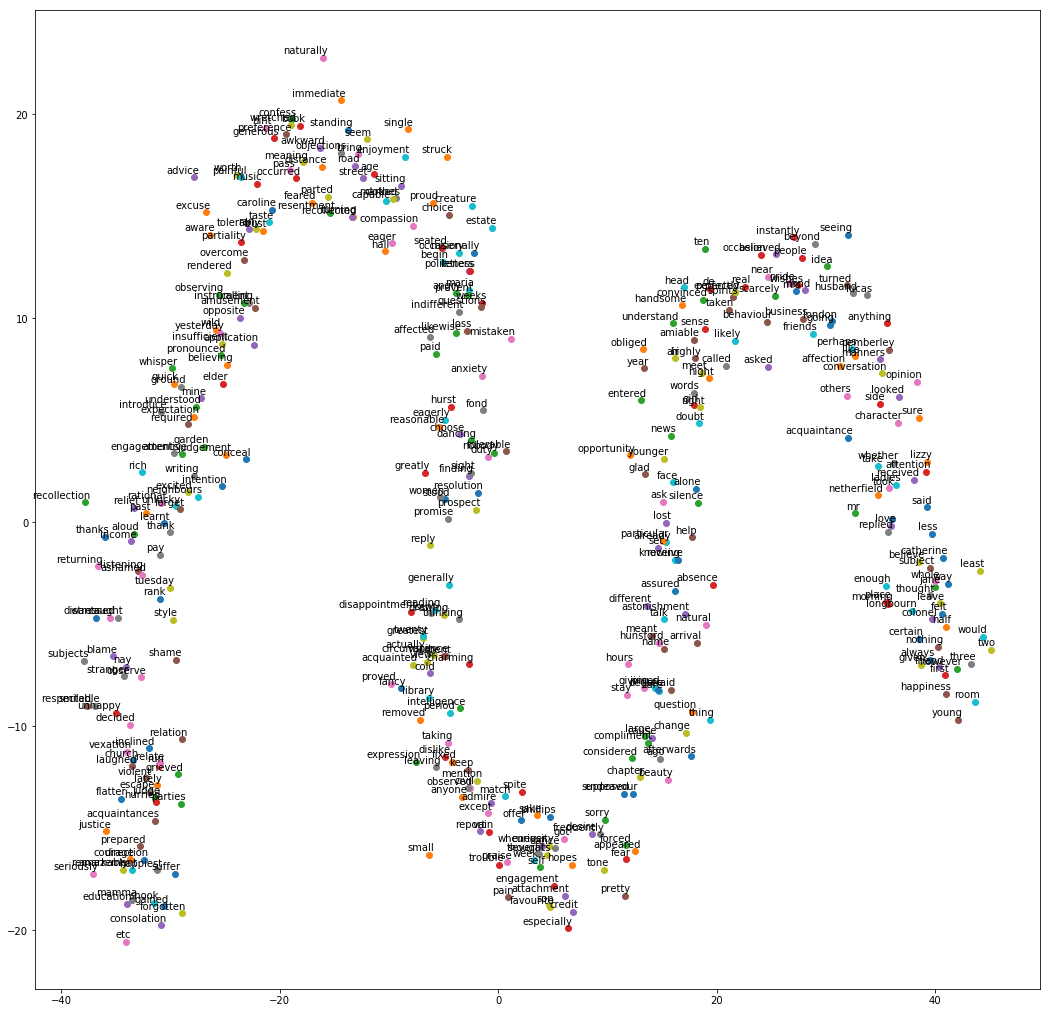

In [30]:


limit = 400
vector_dim = 300

# Getting tokens and vectors
words = []
embedding = np.array([])
i = 0
for word in model.wv.vocab.keys():
    # Break the loop if limit exceeds 
    if i == limit: break

    # Getting token 
    words.append(word)

    # Appending the vectors 
    embedding = np.append(embedding, model[word])

    i += 1

# Reshaping the embedding vector 
embedding = embedding.reshape(limit, vector_dim)


def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    plt.savefig(filename)


# Creating the tsne plot [Warning: will take time]
tsne = TSNE(perplexity=30.0, n_components=2, init='pca', n_iter=5000)

low_dim_embedding = tsne.fit_transform(embedding)

# Finally plotting and saving the fig 
plot_with_labels(low_dim_embedding, words)

# Using pre-trained word embeddings 


In this part we'll demonstrate how to use download, load and use Google's pretrained word vectors in gensim. These word vectors are 300 dimensional and they were trained on a corpus of Google News Dataset with around 100 billion words. They have word vectors for a vocabulary of around 3 million words.

In [ ]:
import gensim

# Text Classification using Word Embeddings

For a short demonstration of text classification of word embeddings we'll use a small dataset from Kaggle containing recent 3000 tweets from Hilary Clinton and Donald Trump that were collected during the election. The dataset is named ["Clinton-Trump Tweets"](https://www.kaggle.com/benhamner/clinton-trump-tweets) and can be collected from Kaggle. The classification problem would be to find whether Hilary or Trump tweeted some particulr tweet given the tweet text. In other words it's a binary classification problem given some text. 

In [60]:
import pandas as pd
tweets = pd.read_csv("tweets.csv")
tweets.head()

,id,handle,text,is_retweet,original_author,time,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,...,place_type,place_country_code,place_country,place_contained_within,place_attributes,place_bounding_box,source_url,truncated,entities,extended_entities
0,780925634159796224,HillaryClinton,The question in this election: Who can put the...,False,NaN,2016-09-28T00:22:34,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/Xr...,{'media': [{'display_url': 'pic.twitter.com/Xr...
1,780916180899037184,HillaryClinton,"Last night, Donald Trump said not paying taxes...",True,timkaine,2016-09-27T23:45:00,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,http://twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/t0...,{'media': [{'display_url': 'pic.twitter.com/t0...
2,780911564857761793,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her...,True,POTUS,2016-09-27T23:26:40,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [{'id_str': '1536791610', 'n...",NaN
3,780907038650068994,HillaryClinton,"If we stand together, there's nothing we can't...",False,NaN,2016-09-27T23:08:41,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/Q3...,{'media': [{'display_url': 'pic.twitter.com/Q3...
4,780897419462602752,HillaryClinton,Both candidates were asked about how they'd co...,False,NaN,2016-09-27T22:30:27,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [], 'symbols': [], 'urls': [...",NaN


In [61]:
tweets.columns

Index(['id', 'handle', 'text', 'is_retweet', 'original_author', 'time',
       'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_user_id', 'is_quote_status', 'lang', 'retweet_count',
       'favorite_count', 'longitude', 'latitude', 'place_id',
       'place_full_name', 'place_name', 'place_type', 'place_country_code',
       'place_country', 'place_contained_within', 'place_attributes',
       'place_bounding_box', 'source_url', 'truncated', 'entities',
       'extended_entities'],
      dtype='object')